In [31]:
# wd = '/mnt/openfact/users/msawinski/factue-task2'
wd = '/Users/marcinsawinski/Documents/GitHub/factue-task2'
import sys, os
os.chdir(wd)

In [32]:
import pandas as pd
from pathlib import Path
import os
root = Path("data/llm_output/persuasion/detect/GPT_41_MINI")
# Example path template
files = root.rglob("*/dev/pl/*.parquet")

# Read all files and add file path as a column
df_list = []
for f in files:
    df_part = pd.read_parquet(f)
    df_part['source_file'] = f  # add the file path
    df_list.append(df_part)

# Combine into one DataFrame
df = pd.concat(df_list, ignore_index=True)
df['split'] = df.source_file.astype(str).str.split('/',expand=True)[7]
df['partno'] = df.source_file.astype(str).str.split('/',expand=True)[9].str.split('_',expand=True)[1].str.split('.',expand=True)[0].astype(int)

In [33]:
df['prompt_version'].value_counts()

prompt_version
v001    2500
v002    2500
Name: count, dtype: int64

In [34]:
df.head(3)

,filename,start,end,text_lang,text,label_bin,label_multi,base_split,Questioning_the_Reputation,Name_Calling-Labeling,...,think_content,verdict,extra_properties,pred,gold,source_file,status,error,split,partno
0,pl_defence_22_05_2024_n01.txt,6716,7011,PL,Pójdźmy dalej. Pan mówi o dialogu z Niemcami.\...,True,[Questioning_the_Reputation],train,[],[],...,[None],[1],[None],1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,dev,3
1,pl_abortion_11_04_2024_n01.txt,3909,4029,PL,Lewica składa ustawę dotyczącą dekryminalizacj...,True,"[Conversation_Killer, Appeal_to_Values, False_...",trial,[],[],...,[None],[1],[None],1,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,dev,3
2,pl_eu_12_06_2024_n02.txt,5588,5843,PL,Druga dotyczy pozycji pana prezydenta. Chciałe...,True,[Doubt],train,[],[],...,[None],[0],[None],0,0,data/llm_output/persuasion/detect/GPT_41_MINI/...,NaN,NaN,dev,3


In [35]:
df[df.split=='dev'].groupby(["prompt_name","text_lang","model_name","split"])['filename'].agg("count").reset_index()

,prompt_name,text_lang,model_name,split,filename
0,Appeal_to_Authority,PL,gpt-4.1-mini,dev,200
1,Appeal_to_Fear-Prejudice,PL,gpt-4.1-mini,dev,200
2,Appeal_to_Hypocrisy,PL,gpt-4.1-mini,dev,200
3,Appeal_to_Pity,PL,gpt-4.1-mini,dev,200
4,Appeal_to_Popularity,PL,gpt-4.1-mini,dev,200
5,Appeal_to_Time,PL,gpt-4.1-mini,dev,200
6,Appeal_to_Values,PL,gpt-4.1-mini,dev,200
7,Causal_Oversimplification,PL,gpt-4.1-mini,dev,200
8,Consequential_Oversimplification,PL,gpt-4.1-mini,dev,200
9,Conversation_Killer,PL,gpt-4.1-mini,dev,200


In [36]:
def normalize_binary(x):
    return 1 if str(x).strip().lower() in {'1', 'true'} else 0

In [37]:
df['source_file'].value_counts().sort_index()
df['gold'] = df['gold'].apply(normalize_binary)
df['pred'] = df['pred'].apply(normalize_binary)
df['split'] = df.source_file.astype(str).str.split('/',expand=True)[7]

In [38]:
df_all = df.copy()

In [39]:
df_all.model_name.value_counts()

model_name
gpt-4.1-mini    5000
Name: count, dtype: int64

In [40]:
df = df_all[(df_all['partno']<10)]
# df = df_all
df['prompt_version'].value_counts()

prompt_version
v001    2500
v002    2500
Name: count, dtype: int64

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for prompt_name in df['prompt_name'].unique():
    for prompt_version in df.loc[df['prompt_name'] == prompt_name, 'prompt_version'].unique():
        for model_name in df.loc[(df['prompt_name'] == prompt_name) & (df['prompt_version'] == prompt_version), 'model_name'].unique():
            group = df[
                (df['prompt_name'] == prompt_name) &
                (df['prompt_version'] == prompt_version) &
                (df['model_name'] == model_name)
            ]
            if len(group) > 0:
                row = {
                    'prompt_name': prompt_name,
                    'prompt_version': prompt_version,
                    'model_name': model_name,
                    'accuracy': accuracy_score(group['gold'], group['pred']),
                    'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                    'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                    'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                    'support': len(group)
                }
                rows.append(row)

results = pd.DataFrame(rows)
results[['accuracy', 'precision','recall', 'f1']] = results[['accuracy', 'precision','recall', 'f1']].round(2)
results.sort_values(by=['prompt_name','prompt_version'])

,prompt_name,prompt_version,model_name,accuracy,precision,recall,f1,support
32,Appeal_to_Authority,v001,gpt-4.1-mini,0.87,0.20,0.75,0.32,100
33,Appeal_to_Authority,v002,gpt-4.1-mini,0.84,0.17,0.75,0.27,100
14,Appeal_to_Fear-Prejudice,v001,gpt-4.1-mini,0.81,0.33,0.90,0.49,100
15,Appeal_to_Fear-Prejudice,v002,gpt-4.1-mini,0.82,0.36,1.00,0.53,100
20,Appeal_to_Hypocrisy,v001,gpt-4.1-mini,0.94,0.50,0.33,0.40,100
21,Appeal_to_Hypocrisy,v002,gpt-4.1-mini,0.89,0.27,0.50,0.35,100
18,Appeal_to_Pity,v001,gpt-4.1-mini,0.88,0.47,0.82,0.60,100
19,Appeal_to_Pity,v002,gpt-4.1-mini,0.83,0.38,0.91,0.54,100
8,Appeal_to_Popularity,v001,gpt-4.1-mini,0.87,0.50,0.31,0.38,100
9,Appeal_to_Popularity,v002,gpt-4.1-mini,0.82,0.39,0.69,0.50,100


In [42]:
pivoted = results.pivot_table(
    index='prompt_name',
    columns='prompt_version',
    values=['accuracy', 'precision', 'recall', 'f1']
)
pivoted.columns = [f"{model}_{metric}" for metric, model in pivoted.columns]
pivoted = pivoted.reset_index()
pivoted

,prompt_name,v001_accuracy,v002_accuracy,v001_f1,v002_f1,v001_precision,v002_precision,v001_recall,v002_recall
0,Appeal_to_Authority,0.87,0.84,0.32,0.27,0.20,0.17,0.75,0.75
1,Appeal_to_Fear-Prejudice,0.81,0.82,0.49,0.53,0.33,0.36,0.90,1.00
2,Appeal_to_Hypocrisy,0.94,0.89,0.40,0.35,0.50,0.27,0.33,0.50
3,Appeal_to_Pity,0.88,0.83,0.60,0.54,0.47,0.38,0.82,0.91
4,Appeal_to_Popularity,0.87,0.82,0.38,0.50,0.50,0.39,0.31,0.69
5,Appeal_to_Time,0.90,0.71,0.58,0.33,0.44,0.20,0.88,0.88
6,Appeal_to_Values,0.78,0.83,0.71,0.74,0.55,0.63,1.00,0.89
7,Causal_Oversimplification,0.69,0.54,0.28,0.21,0.16,0.12,1.00,1.00
8,Consequential_Oversimplification,0.82,0.62,0.00,0.05,0.00,0.03,0.00,0.50
9,Conversation_Killer,0.60,0.59,0.39,0.39,0.25,0.25,0.93,0.93


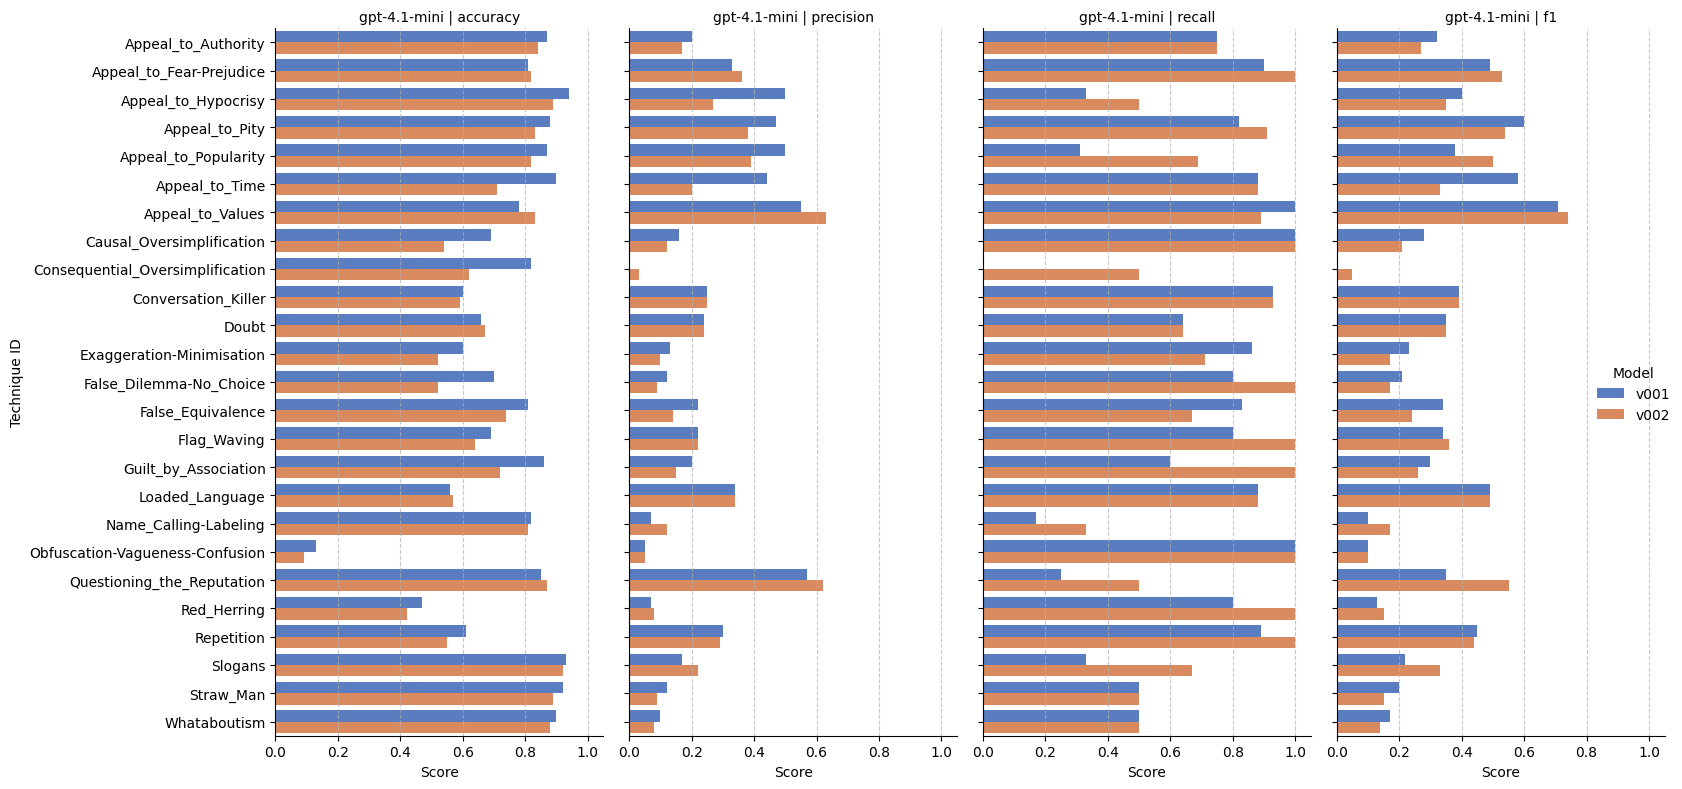

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the results dataframe
metrics_df = results.melt(
    id_vars=['prompt_name', 'prompt_version', 'model_name'],
    value_vars=['accuracy', 'precision', 'recall', 'f1'],
    var_name='metric',
    value_name='score'
).sort_values(['prompt_name', 'prompt_version', 'model_name'])

# Create FacetGrid
g = sns.FacetGrid(
    metrics_df, 
    row="model_name", 
    col="metric", 
    sharex=True, 
    sharey=True, 
    height=8, 
    aspect=0.5
)

# Use map_dataframe and assign `hue` in the barplot call
g.map_dataframe(
    sns.barplot, 
    x="score", 
    y="prompt_name", 
    hue="prompt_version", 
    errorbar=None, 
    palette='muted',
    # legend=False  # Disable auto-legend here
)
# for i, ax in enumerate(g.axes.flat):
#     row_idx, col_idx = divmod(i, g.axes.shape[1])
#     if col_idx != 0:
#         ax.set_ylabel("")
#         ax.set_yticklabels([])

# Add a single legend to the full figure
g.add_legend(title='Model')
g.set_axis_labels("Score", "Technique ID")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# total

In [44]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for prompt_version in df['prompt_version'].unique():
    for model_name in df.loc[(df['prompt_version'] == prompt_version), 'model_name'].unique():
        group = df[
            (df['prompt_version'] == prompt_version) &
            (df['model_name'] == model_name)
        ]
        if len(group) > 0:
            row = {
                'prompt_version': prompt_version,
                'model_name': model_name,
                'accuracy': accuracy_score(group['gold'], group['pred']),
                'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                'support': len(group)
            }
            rows.append(row)

results_total = pd.DataFrame(rows)
results_total[['accuracy', 'precision','recall', 'f1']] = results_total[['accuracy', 'precision','recall', 'f1']].round(2)
results_total

,prompt_version,model_name,accuracy,precision,recall,f1,support
0,v001,gpt-4.1-mini,0.75,0.23,0.74,0.35,2500
1,v002,gpt-4.1-mini,0.69,0.20,0.82,0.33,2500


# lang


In [45]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for prompt_name in df['prompt_name'].unique():
    for text_lang in df.loc[df['prompt_name'] == prompt_name, 'text_lang'].unique():
        for model_name in df.loc[(df['prompt_name'] == prompt_name) & (df['text_lang'] == text_lang), 'model_name'].unique():
            group = df[
                (df['prompt_name'] == prompt_name) &
                (df['text_lang'] == text_lang) &
                (df['model_name'] == model_name)
            ]
            if len(group) > 0:
                row = {
                    'prompt_name': prompt_name,
                    'text_lang': text_lang,
                    'model_name': model_name,
                    'accuracy': accuracy_score(group['gold'], group['pred']),
                    'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                    'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                    'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                    'support': len(group)
                }
                rows.append(row)

results = pd.DataFrame(rows)
results[['accuracy', 'precision','recall', 'f1']] = results[['accuracy', 'precision','recall', 'f1']].round(2)
results

,prompt_name,text_lang,model_name,accuracy,precision,recall,f1,support
0,Exaggeration-Minimisation,PL,gpt-4.1-mini,0.56,0.11,0.79,0.20,200
1,Obfuscation-Vagueness-Confusion,PL,gpt-4.1-mini,0.11,0.05,1.00,0.10,200
2,Conversation_Killer,PL,gpt-4.1-mini,0.60,0.25,0.93,0.39,200
3,Repetition,PL,gpt-4.1-mini,0.58,0.29,0.94,0.45,200
4,Appeal_to_Popularity,PL,gpt-4.1-mini,0.84,0.42,0.50,0.46,200
5,False_Dilemma-No_Choice,PL,gpt-4.1-mini,0.61,0.10,0.90,0.19,200
6,Appeal_to_Values,PL,gpt-4.1-mini,0.80,0.59,0.94,0.72,200
7,Appeal_to_Fear-Prejudice,PL,gpt-4.1-mini,0.82,0.35,0.95,0.51,200
8,Red_Herring,PL,gpt-4.1-mini,0.44,0.08,0.90,0.14,200
9,Appeal_to_Pity,PL,gpt-4.1-mini,0.86,0.42,0.86,0.57,200
